# Duffing Oscillator — Lyapunov Benchmark

Pipeline:
1. Define the Duffing problem (`duffing_oscillator.py`)
2. Train a neural Lyapunov candidate V via composite loss (`lyapunov.py`)
3. Verify using the hyperplane arrangement method (`hyperplane.py`)

In [1]:
# Use this to auto-reload changed modules in the notebook
%load_ext autoreload
%autoreload 2

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from duffing_oscillator import DuffingProblem as duff
from lyapunov import train_model_lyapunov_general
from hyperplane import full_method

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Problem setup

In [21]:
print(duff)

<class 'duffing_oscillator.DuffingProblem'>


In [23]:
# Hyperparameters
HIDDEN_SIZE = 50

NUM_EPOCHS = 300
LEARNING_RATE = 0.01
GRID_PTS = 300  # training grid resolution per axis

x1_min, x1_max = duff.region[0, 0].item(), duff.region[0, 1].item()
x2_min, x2_max = duff.region[1, 0].item(), duff.region[1, 1].item()

dynamics = duff.dynamics.to(device)
model = duff.nn_lyapunov.to(device)

# Training grid
x1_t = torch.linspace(x1_min, x1_max, GRID_PTS)
x2_t = torch.linspace(x2_min, x2_max, GRID_PTS)
x1g, x2g = torch.meshgrid(x1_t, x2_t, indexing="ij")
x_train = torch.stack([x1g.flatten(), x2g.flatten()], dim=1).to(device)

## 2. Train Lyapunov function

In [24]:
model = train_model_lyapunov_general(
    model,
    x_train,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    dynamics=dynamics,
)

Epoch [100/300], Loss: 1.7117
Epoch [200/300], Loss: 0.1486
Epoch [300/300], Loss: 0.6806


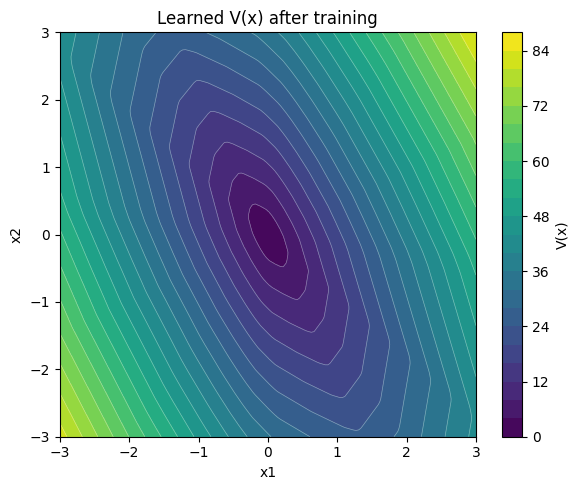

In [25]:
model.cpu()

# Evaluate V on a plot grid (reused in the verification plot below)
x1_plot = np.linspace(x1_min, x1_max, 150)
x2_plot = np.linspace(x2_min, x2_max, 150)
X1g, X2g = np.meshgrid(x1_plot, x2_plot)
plot_pts = torch.tensor(
    np.stack([X1g.ravel(), X2g.ravel()], axis=1), dtype=torch.float32
)
with torch.no_grad():
    V = model(plot_pts).numpy().reshape(X1g.shape)

plt.figure(figsize=(6, 5))
plt.contourf(X1g, X2g, V, levels=20, cmap="viridis")
plt.colorbar(label="V(x)")
plt.contour(X1g, X2g, V, levels=20, colors="white", linewidths=0.5, alpha=0.4)
plt.title("Learned V(x) after training")
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

In [ ]:
dynamics.cpu()

counterexamples, polygons, vertex_dict = full_method(model, dynamics, duff.region)
print(f"\nResult: {len(counterexamples)} counterexample(s) found.")

Getting intersection points...
  done (0.011s)  — 938 points
Building planar graph...
  done (0.021s)
Finding polygons...
  done (0.367s)  — 885 polygons
Running verification...


In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

# V level sets as background
ax.contourf(X1g, X2g, V, levels=20, cmap="viridis", alpha=0.5)
ax.contour(X1g, X2g, V, levels=20, colors="white", linewidths=0.4, alpha=0.3)

# Polygon tessellation
for poly_nodes in polygons:
    coords = [vertex_dict[v] for v in poly_nodes]
    xs = [c[0] for c in coords] + [coords[0][0]]
    ys = [c[1] for c in coords] + [coords[0][1]]
    ax.plot(xs, ys, "k-", linewidth=0.6, alpha=0.5)

# Counterexamples
if counterexamples:
    cx = [p[0] for p in counterexamples]
    cy = [p[1] for p in counterexamples]
    ax.scatter(
        cx,
        cy,
        c="red",
        s=50,
        zorder=5,
        label=f"Counterexamples ({len(counterexamples)})",
    )
    ax.legend()

ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.set_title("Hyperplane verification: polygon tessellation + counterexamples")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.tight_layout()
plt.show()